RF Model:

5 parts

The first part contains the imports

The second part is the main code which actually contains the RF function and runs the MCCV loop (set to 200 iterations with 90/10 train test)  but can be changed via n_splits and test_fraction

The third part is the predicted versus actual plot 

The fourth part is the prediction part which contains the RF prediction of the 4950 dataset of different molecules

The fifth part is optional and it removes all the molecules that were in the training set from the large predicted set (to avoid artifically better results)


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv("data.csv")


numeric_features = ['ionic_character_2nd_root', 'Diff_Ionic_4th_root','Sum_Affinity','Prod_Ionic_Recip']
categorical_features = ['Group1', 'Group2', 'Period1', 'Period2']
target = 'dipole_moment'
molecule_column = 'Molecule' ##For Grouping##

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

X = preprocessor.fit_transform(data[numeric_features + categorical_features])
y = data[target].values.flatten()
molecules = data[molecule_column].values

n_splits = 200
test_fraction = 0.1

all_predictions_test = {}
all_predictions_train = {}
rmse_train_values = []
rmse_test_values = []
mae_train_values = []
mae_test_values = []
per_sample_test_errors = {}
per_sample_train_errors = {}
lower_bounds_test = {}
upper_bounds_test = {}

unique_molecules = np.unique(molecules)
n_total_unique_molecules = len(unique_molecules)
n_test_molecules = int(test_fraction * n_total_unique_molecules)
n_train_molecules = n_total_unique_molecules - n_test_molecules

true_iteration = 0
attempt = 0
max_attempts = 10000

print(f"Total unique molecules: {n_total_unique_molecules}")
print(f"Number of test molecules per fold: {n_test_molecules}")
print(f"Number of training molecules per fold: {n_train_molecules}")

while true_iteration < n_splits and attempt < max_attempts:
    attempt += 1

    test_molecules_sample = np.random.choice(unique_molecules, size=n_test_molecules, replace=False)
    train_molecules_sample = np.array(list(set(unique_molecules) - set(test_molecules_sample)))

    train_index = np.where(np.isin(molecules, train_molecules_sample))[0]
    test_index = np.where(np.isin(molecules, test_molecules_sample))[0]

    if len(test_index) == 0 or len(train_index) == 0:
        if n_test_molecules == 0 or n_train_molecules == 0:
            print("Warning: n_test_molecules or n_train_molecules is 0.")
            break
        continue

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)

    y_test_pred = rf.predict(X_test)
    y_train_pred = rf.predict(X_train)

    for j, original_idx in enumerate(test_index):
        all_predictions_test.setdefault(original_idx, []).append(y_test_pred[j])
        lower_bounds_test.setdefault(original_idx, []).append(np.nan)
        upper_bounds_test.setdefault(original_idx, []).append(np.nan)
        per_sample_test_errors[original_idx] = per_sample_test_errors.get(original_idx, []) + [(y[original_idx] - y_test_pred[j])**2]

    for j, original_idx in enumerate(train_index):
        all_predictions_train.setdefault(original_idx, []).append(y_train_pred[j])
        per_sample_train_errors[original_idx] = per_sample_train_errors.get(original_idx, []) + [(y[original_idx] - y_train_pred[j])**2]

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    rmse_train_values.append(rmse_train)
    rmse_test_values.append(rmse_test)
    mae_train_values.append(mae_train)
    mae_test_values.append(mae_test)

    true_iteration += 1
    if true_iteration % 10 == 0 or true_iteration == 1:
        print(f"Iteration {true_iteration} of {n_splits} (attempt {attempt}): "
              f"RMSE Train: {rmse_train:.4f}, RMSE Test: {rmse_test:.4f}, "
              f"MAE Train: {mae_train:.4f}, MAE Test: {mae_test:.4f}")

if true_iteration < n_splits:
    print(f"Warning: Only {true_iteration} iterations completed.")

def aggregate_predictions(pred_dict, original_y_values):
    actuals, avg_preds, std_preds, sorted_indices = [], [], [], []
    for index in sorted(pred_dict.keys()):
        preds = pred_dict[index]
        avg_preds.append(np.mean(preds))
        std_preds.append(np.std(preds))
        actuals.append(original_y_values[index])
        sorted_indices.append(index)
    return sorted_indices, actuals, avg_preds, std_preds

def aggregate_bounds(bound_dict):
    return [np.nan for _ in sorted(bound_dict.keys())]

sorted_indices_test, actuals_test, avg_preds_test, std_preds_test = aggregate_predictions(all_predictions_test, y)
sorted_indices_train, actuals_train, avg_preds_train, std_preds_train = aggregate_predictions(all_predictions_train, y)
avg_lower_bounds_test = aggregate_bounds(lower_bounds_test)
avg_upper_bounds_test = aggregate_bounds(upper_bounds_test)

results_df_test = pd.DataFrame({
    'index': sorted_indices_test,
    'molecule': [molecules[idx] for idx in sorted_indices_test],
    'actual': actuals_test,
    'average_prediction': avg_preds_test,
    'standard_deviation': std_preds_test,
    'avg_lower_bound': avg_lower_bounds_test,
    'avg_upper_bound': avg_upper_bounds_test
})

results_df_train = pd.DataFrame({
    'index': sorted_indices_train,
    'molecule': [molecules[idx] for idx in sorted_indices_train],
    'actual': actuals_train,
    'average_prediction': avg_preds_train,
    'standard_deviation': std_preds_train
})

results_df_test.to_csv('mccv_test_results.csv', index=False)
results_df_train.to_csv('mccv_train_results.csv', index=False)

final_rmse_test = np.sqrt(np.mean([np.mean(sq_errors) for sq_errors in per_sample_test_errors.values()]))
final_rmse_train = np.sqrt(np.mean([np.mean(sq_errors) for sq_errors in per_sample_train_errors.values()]))

print("MCCV results saved to mccv_test_results.csv and mccv_train_results.csv")
print(f"Overall Average Training RMSE: {np.mean(rmse_train_values):.4f}")
print(f"Overall Average Testing RMSE: {np.mean(rmse_test_values):.4f}")
print(f"Training RMSE Std Dev: {np.std(rmse_train_values):.4f}")
print(f"Testing RMSE Std Dev: {np.std(rmse_test_values):.4f}")
print(f"Min/Max Train RMSE: {np.min(rmse_train_values):.4f} / {np.max(rmse_train_values):.4f}")
print(f"Min/Max Test RMSE: {np.min(rmse_test_values):.4f} / {np.max(rmse_test_values):.4f}")
print("---")
print(f"Final Aggregated Training RMSE: {final_rmse_train:.4f}")
print(f"Final Aggregated Testing RMSE: {final_rmse_test:.4f}")
print("---")
print(f"Overall Average Training MAE: {np.mean(mae_train_values):.4f}")
print(f"Overall Average Testing MAE: {np.mean(mae_test_values):.4f}")
print(f"Training MAE Std Dev: {np.std(mae_train_values):.4f}")
print(f"Testing MAE Std Dev: {np.std(mae_test_values):.4f}")
print(f"Min/Max Train MAE: {np.min(mae_train_values):.4f} / {np.max(mae_train_values):.4f}")
print(f"Min/Max Test MAE: {np.min(mae_test_values):.4f} / {np.max(mae_test_values):.4f}")


Total unique molecules: 273
Number of test molecules per fold: 27
Number of training molecules per fold: 246
Iteration 1 of 200 (attempt 1): RMSE Train: 0.2107, RMSE Test: 0.8747, MAE Train: 0.1374, MAE Test: 0.5916
Iteration 10 of 200 (attempt 10): RMSE Train: 0.2011, RMSE Test: 0.9458, MAE Train: 0.1315, MAE Test: 0.6678
Iteration 20 of 200 (attempt 20): RMSE Train: 0.2134, RMSE Test: 1.6079, MAE Train: 0.1359, MAE Test: 0.9307
Iteration 30 of 200 (attempt 30): RMSE Train: 0.1965, RMSE Test: 1.2973, MAE Train: 0.1330, MAE Test: 0.7102
Iteration 40 of 200 (attempt 40): RMSE Train: 0.2013, RMSE Test: 1.0987, MAE Train: 0.1303, MAE Test: 0.7605
Iteration 50 of 200 (attempt 50): RMSE Train: 0.2381, RMSE Test: 0.9450, MAE Train: 0.1445, MAE Test: 0.6425
Iteration 60 of 200 (attempt 60): RMSE Train: 0.2314, RMSE Test: 0.7927, MAE Train: 0.1480, MAE Test: 0.5113
Iteration 70 of 200 (attempt 70): RMSE Train: 0.2344, RMSE Test: 0.6100, MAE Train: 0.1470, MAE Test: 0.4651
Iteration 80 of 200 (

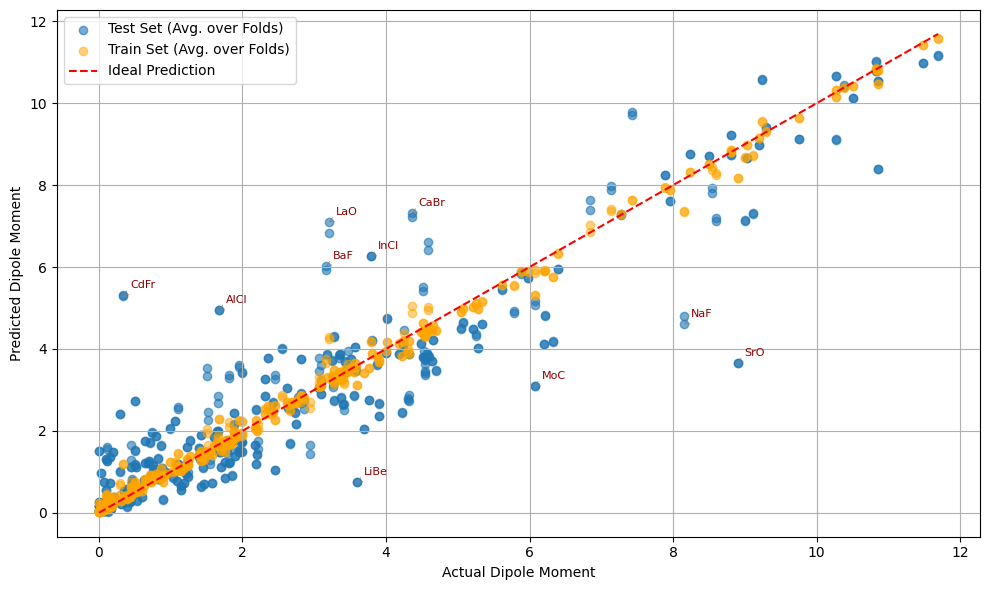

In [4]:
def aggregate_predictions(pred_dict, original_y_values):
    actuals, avg_preds, std_preds, indices = [], [], [], []
    for idx in sorted(pred_dict.keys()):
        preds = pred_dict[idx]
        avg_preds.append(np.mean(preds))
        std_preds.append(np.std(preds))
        actuals.append(original_y_values[idx])
        indices.append(idx)
    return pd.DataFrame({
        'index': indices,
        'molecule': [molecules[i] for i in indices],
        'actual': actuals,
        'average_prediction': avg_preds,
        'std_prediction': std_preds
    })

results_df_test = aggregate_predictions(all_predictions_test, y)
results_df_train = aggregate_predictions(all_predictions_train, y)

# --- Compute absolute errors for test set ---
results_df_test['abs_error'] = np.abs(results_df_test['actual'] - results_df_test['average_prediction'])

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Scatter plot test set (no error bars)
plt.scatter(results_df_test['actual'], results_df_test['average_prediction'],
            alpha=0.6, label='Test Set (Avg. over Folds)')

# Scatter plot train set (no error bars)
plt.scatter(results_df_train['actual'], results_df_train['average_prediction'],
            color='orange', alpha=0.5, label='Train Set (Avg. over Folds)')

# Ideal prediction line
min_val = min(results_df_test['actual'].min(), results_df_train['actual'].min())
max_val = max(results_df_test['actual'].max(), results_df_train['actual'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')

plt.xlabel('Actual Dipole Moment')
plt.ylabel('Predicted Dipole Moment')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate top 10 unique molecules with largest errors in test set
outliers_df = results_df_test.sort_values(by='abs_error', ascending=False)

seen_molecules = set()
labeled_count = 0

for _, row in outliers_df.iterrows():
    mol = row['molecule']
    if mol not in seen_molecules:
        seen_molecules.add(mol)
        plt.annotate(mol,
                     (row['actual'], row['average_prediction']),
                     textcoords="offset points",
                     xytext=(5, 5),
                     ha='left',
                     fontsize=8,
                     color='darkred',
                     arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
        labeled_count += 1
    if labeled_count >= 10:
        break

# Save and show plot
plt.savefig('dipole_moment_prediction_RF.png')
plt.show()



In [5]:

# ---- Load datasets ----
train_data = pd.read_csv("data.csv")
train_data['dipole_moment'] = train_data['dipole_moment'].abs()
big_set = pd.read_csv("large_set.csv")

# ---- Feature settings ----
numeric_features = ['ionic_character', 'eletron_affinity2', 'eletron_affinity1',
                    'ionic_potential1', 'ionic_potential2']
categorical_features = ['Group1', 'Group2', 'Period1', 'Period2']
target = 'dipole_moment'

# ---- Column Transformer for preprocessing ----
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# ---- Prepare features ----
X_train = train_data[numeric_features + categorical_features]
y_train = train_data[target].values.flatten()
X_big = big_set[numeric_features + categorical_features]

# ---- Preprocess data ----
X_train_processed = preprocessor.fit_transform(X_train)
X_big_processed = preprocessor.transform(X_big)

# ---- Train Random Forest Model ----
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_processed, y_train)

# ---- Predict on big_set ----
y_big_pred = model.predict(X_big_processed)

# ---- Save results ----
big_set_results = big_set.copy()
big_set_results['predicted_dipole_moment'] = y_big_pred

big_set_results.to_csv("RF_predictions.csv", index=False)
print("Predictions saved to RF_predictions.csv")


Predictions saved to RF_predictions.csv


In [6]:
df1=pd.read_csv("data.csv")
df2=pd.read_csv("RF_predictions.csv")
pairs_df1 = set(tuple(sorted([row['atom 1'], row['atom 2']])) for _, row in df1.iterrows())
mask = df2.apply(lambda row: tuple(sorted([row['Atom 1'], row['Atom 2']])) not in pairs_df1, axis=1)
df2_filtered = df2[mask].reset_index(drop=True)
df2_filtered.to_csv("RF_predictions_no_training.csv",index=False)